# Exhibition: t-Distributed Stochastic Neighbor Embedding (t-SNE)

The main steps of the t-SNE procedure to be implemented:

* compute pairwise affinities $p_{j|i}$ with perplexity perp using $p_{j|i} = \frac{\exp(-||x_i - x_j||^2/2\sigma^2)}{\sum_{k|k \neq i} \exp(-||x_i - x_k||^2/2\sigma^2)}$ for $j \neq i$, and $p_{i|i} = 0$.

* Optimize the perplexity for each element i to give the target perplexity

* Symmetrize the affinity matrix using $p_{ij} = \frac{p_{j|i}+p_{i|j}}{2N}$

* Consider an initial embedding $Y^{0}$


* Repeat for multiple iterations:

   * Compute the affinities in the embedded space $q_{ij} = \frac{(1 + ||y_i - y_j||^2)^{-1}}{\sum_{k} \sum_{l|l \neq k} (1 + ||y_k - y_l||^2)^{-1}}$ for $i \neq j$, and $q_{ii} = 0$.
   
   * Compute the gradient $\frac{\partial C}{\partial Y}$ using $\frac{\partial C}{\partial Y_i} = 4 \sum_{j} (p_{ij}-q_{ij})(y_i-y_j)(1 + ||y_i - y_j||^2)^{-1}$
   
   * Update the embedding using the update rule $Y^{t} = Y^{t-1} + \eta \frac{\partial C}{\partial Y} + \alpha (t)( Y^{t-1}-Y^{t-2})$, where $Y^{t}$ is the value of $Y$ at time $t$, where $Y^{t}=(0,0,...,0)$ for $t < 0$ and where $\alpha (t) = 0.5$ at the beginning of the training procedure and $0.9$ towards the end.
   

* Return the final embedding $Y^{T}$ where $T$ is the number of iterations

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import numpy as np
import scipy, scipy.spatial
import sklearn, sklearn.datasets
from sklearn.metrics import pairwise_distances

### Supporting Functions

In [2]:
def getaffinity(X,target):

    N = len(X)
    T = 100

    def getp(D2n):
        up = np.exp(-0.5*D2n)
        up = up * (1-np.identity(len(up))) # do not include diagonal elements
        up = up + 1e-9                        # add numerical stability
        p  = up / up.sum(axis=1,keepdims=True)
        return p

    D2 = scipy.spatial.distance.cdist(X,X,'sqeuclidean')

    sqsigmas = np.logspace(-2,3,T)
    err = np.zeros([T,N])

    for i in range(T):

        p = getp(D2/sqsigmas[i])
        
        entropy = -(p*np.log2(p)).sum(axis=1)

        perp = 2.0**entropy

        err[i] = (perp-target)**2

    sqsigmabest = np.array([sqsigmas[np.argmin(err[:,j])] for j in range(N)])
    
    p = getp(D2/sqsigmabest[:,np.newaxis])
    p = p + p.T
    p = p/p.sum()  
    return p

In [3]:
def student(Y):
    
    N = Y.shape[0]

    dist = (1+pairwise_distances(Y)**2)**(-1)
    
    for i in range(N):
        dist[i][i] = 0

    Q = dist / dist.sum()
    
    return Q

In [4]:
def objective(P,Q):
    # Calculates the objective of t-SNE to minimize. The objective is the
    # KL divergence C = KL(P||Q)
    # 
    # inputs: P - An NxN array containing p_ij
    #         Q - An NxN array containing q_ij
    # return: C - The value of the objective
    Q[Q==0] = 1
    C = (P*np.log(P/Q)).sum()
    return C

In [5]:
def gradient(P,Y):
    # Computes the gradient as described above.
    #
    #inputs: P     - An NxN array containing p_ij
    #        Y     - An Nx2 array containing the embedding
    #return: gradY - the gradient of the objective with respect to Y
    N = Y.shape[0]

    Q = student(Y)

    gradY = np.zeros((N,2))

    for i in range(N):
        
        A = (P[i,:]-Q[i,:])[:,np.newaxis]
        B = np.tile(Y[i,:], (N,1)) - Y
        C = ((1 + np.linalg.norm(B, axis=1))**(-1))[:,np.newaxis]
        
        entry_new = 4 * (A * B * C).sum(axis=0)
        gradY[i,:] = 4 * entry_new
        
    return gradY

### The t-SNE Algorithm

In [6]:
def tSNE(X, Y0, perplexity, learningrate, nbiterations=1000):

    N,d = X.shape
    
    print('get affinity matrix')
    
    # get the affinity matrix in the original space
    P = getaffinity(X,perplexity)
    
    # create initial embedding and update direction
    Y  = Y0*1
    dY = Y*0
    
    print('run t-SNE')
    
    for t in range(nbiterations):

        # compute the pairwise affinities in the embedding space
        Q = student(Y)
        
        # monitor objective
        if t % 100 == 0: print('%3d %.3f'%(t,objective(P,Q)))
        
        # update
        dY = (0.5 if t < 100 else 0.9)*dY + learningrate*gradient(P,Y)
        Y = Y - dY

    return Y

### Testing on Digits Dataset

In [7]:
def get_data():

    D = sklearn.datasets.load_digits()
    # Read only 500 first examples
    X = D.data[:500]
    T = D.target[:500]

    # Normalize them
    X -= X.mean(axis=0)
    X /= (X**2).mean()**.5

    return X,T

In [8]:
# read input dataset
X, color = get_data()

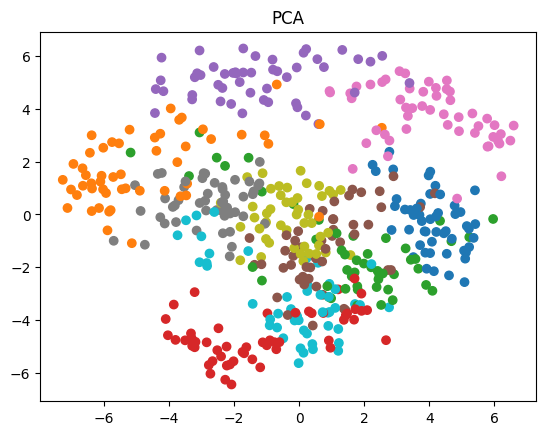

In [9]:
# run PCA
U, W, _ = np.linalg.svd(X,full_matrices=False)
Y0 = U[:,:2]*W[:2]
plt.scatter(*Y0.T,c=color,cmap='tab10'); plt.title('PCA')
plt.show()

get affinity matrix
run t-SNE
  0 2.219
100 0.495
200 0.462
300 0.456
400 0.454
500 0.453
600 0.452
700 0.452
800 0.452
900 0.452


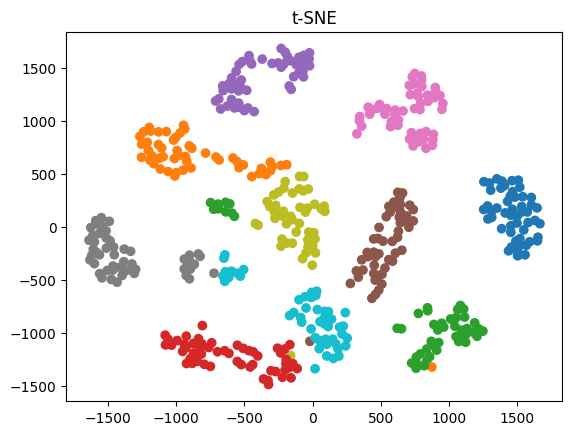

In [10]:
# run TSNE starting with PCA embedding as an initial solution
Y = tSNE(X,Y0,10.0,100.0)
plt.scatter(*Y.T,c=color,cmap='tab10'); plt.title('t-SNE')
plt.show()